# Import Libraries

In [36]:
#source: https://towardsdatascience.com/how-to-compute-satellite-image-statistics-and-use-it-in-pandas-81864a489144
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import gdal
import shapely
import rasterstats
from rasterstats import zonal_stats
import subprocess

# Metadata

Setting the CRS and creating a mask from SPI data from Deltares.

# Name Variables

In [21]:
#Decide bounds
bounds_shp = 'wpsi_country_borders_display/gadm36_0_wpsi_display.shp'
original_rast = 'SPI2020_08.tif'
edited_rast = 'SPI2020_08_180.tif'

# Import Data

In [22]:
raster = rio.open(original_rast)

Raster width: 360
Raster height: 181
Number of bands: 1
Data Type: GTiff
Raster CRS: EPSG:4326
No Data Values: (-3.4028234663852886e+38,)
Total Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 360, 'height': 181, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(1.0, 0.0, -0.5,
       0.0, -1.0, 90.5)}


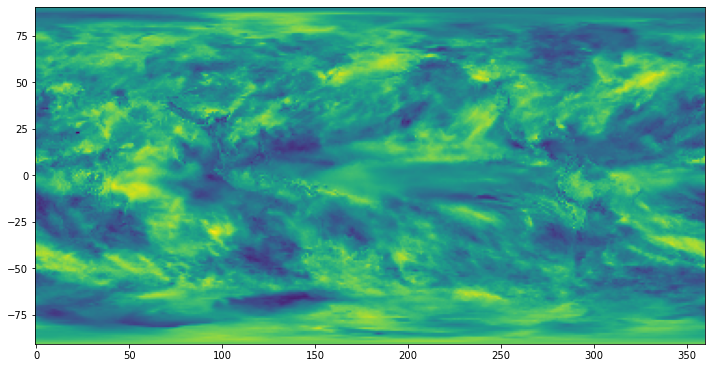

In [23]:
print('Raster width:', raster.width)
print('Raster height:' ,raster.height)
print('Number of bands:', raster.count)
print('Data Type:', raster.driver)
print("Raster CRS:", raster.crs)
print('No Data Values:', raster.nodatavals)
print("Total Metadata:", raster.meta)

fig, ax = plt.subplots(1, figsize=(12, 10))
show(raster, ax=ax)
plt.show()

In [24]:
# Read the raster band as separate variable
band1 = raster.read(1)
# Check type of the variable 'band'
print(type(band1))
# Data type of the values
print(band1.dtype)
# Read all bands
array = raster.read()
# Calculate statistics for each band
stats = []
for band in array:
    stats.append({
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max()})

# Show stats for each channel
stats


<class 'numpy.ndarray'>
float32


[{'min': -4.0, 'mean': 0.10781343, 'median': 0.10403334, 'max': 3.5779264}]

# Import Shapefile and get metadata

In [25]:
#https://www.youtube.com/watch?v=RoeVPBVbscQ
#gdf = gpd.read_file('geometry_adm2/data_working_geometries_gadm36_2.shp')
bounds = gpd.read_file(bounds_shp)

<AxesSubplot:>

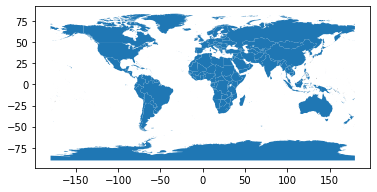

In [26]:
bounds.plot()

In [27]:
#https://www.youtube.com/watch?v=slqZVgB8tIg
len(bounds)
print(bounds.head)
print(bounds.crs)
#most likely used: {'init': 'epsg:4326'}

<bound method NDFrame.head of     GID_0           NAME_0                                           geometry
0     ABW            Aruba  POLYGON ((-69.89912109396329 12.45200195332751...
1     AFG      Afghanistan  POLYGON ((71.00423431156429 38.47541046102398,...
2     AGO           Angola  (POLYGON ((14.00731892832599 -5.85891108797633...
3     AIA         Anguilla  POLYGON ((-63.15781598232167 18.17208290120499...
4     ALA           Ãland  (POLYGON ((21.32361030617074 59.75014114349906...
..    ...              ...                                                ...
251   XSP  Spratly Islands  (POLYGON ((114.3658370972043 10.18055534385411...
252   YEM            Yemen  (POLYGON ((43.41236114525071 12.67125034322876...
253   ZAF     South Africa  POLYGON ((29.65522956958904 -22.12508010955936...
254   ZMB           Zambia  (POLYGON ((27.04047068107712 -17.9616662798748...
255   ZWE         Zimbabwe  POLYGON ((29.9017505642372 -15.62221145609379,...

[256 rows x 3 columns]>
{'init': 

# Overlay Maps

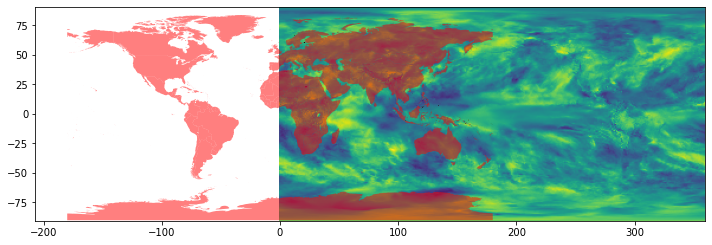

In [28]:
#plot together
fig, ax = plt.subplots(figsize=(12, 10))
show(raster, ax=ax)
bounds.plot(ax=ax, color='red', alpha=.50)
plt.show();

# Open GDAL and transform raster to correct extent

In [42]:
raster_ds = gdal.Open("SPI2020_08.tif")
print (raster_ds)
image_gdal = raster_ds.GetRasterBand(1).ReadAsArray()
print (image_gdal.shape)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fa0ed6ac4e0> >
(181, 360)


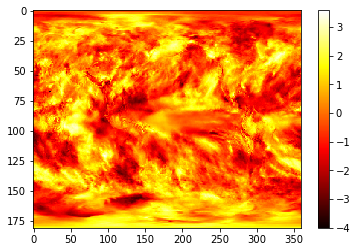

In [43]:
import matplotlib.pyplot as plt
plt.imshow(band1, cmap = "hot", interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

In [44]:
gdal_expression = ('gdalwarp -t_srs WGS84 SPI2020_08.tif SPI2020_08_180.tif  -wo SOURCE_EXTRA=1000 --config CENTER_LONG 0')
print(gdal_expression)
subprocess.check_output(gdal_expression, shell=True)

gdalwarp -t_srs WGS84 SPI2020_08.tif SPI2020_08_180.tif  -wo SOURCE_EXTRA=1000 --config CENTER_LONG 0


b'Creating output file that is 360P x 181L.\nProcessing SPI2020_08.tif [1/1] : 0Using internal nodata values (e.g. -3.40282e+38) for image SPI2020_08.tif.\nCopying nodata values from source SPI2020_08.tif to destination SPI2020_08_180.tif.\n...10...20...30...40...50...60...70...80...90...100 - done.\n'

In [45]:
raster_ds2 = gdal.Open("SPI2020_08_180.tif")
print (raster_ds2)
image_gdal2 = raster_ds2.GetRasterBand(1).ReadAsArray()
print (image_gdal.shape)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fa0d7673f30> >
(181, 360)


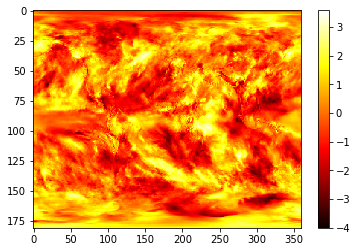

In [46]:
plt.imshow(image_gdal2, cmap = "hot", interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()